In [22]:
import os, re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [24]:
!pip install transformers tika yake

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
cd drive/MyDrive/CYsyphus/indexed_corpus

[Errno 2] No such file or directory: 'drive/MyDrive/CYsyphus/indexed_corpus'
/content/drive/.shortcut-targets-by-id/1X1APgHBDiD-6ucORNx5eM_SWKZYOgyvz/indexed_corpus


In [27]:
def remove_punc(pdf_content):
    punc = ['• ', '· ', '&', '~', ' o ', '\uf0a7', '\uf03c', '\uf0b7', 
            '–', '()', '[…]', '| ', '© ', '(Insert Scale)', '_', '%', '[', ']', 'Ü ']
    for p in punc:
        pdf_content = pdf_content.replace(p, '')
    return pdf_content

def remove_bulleted_points(pdf_content):
    pdf_content = re.sub(r'\.+ [0-9]+', '.', pdf_content)
    pdf_content = re.sub(r'\.+[0-9]+', '.', pdf_content)
    pdf_content = re.sub(r'\.+', '.', pdf_content)

    pdf_content = re.sub(r'\([0-9]+\)', '', pdf_content)
    pdf_content = re.sub(r'[0-9]+\)', '', pdf_content)
    pdf_content = re.sub(r'[0-9]+.', '', pdf_content)
    pdf_content = re.sub(r'\([a-zA-Z]\)', '', pdf_content)
    pdf_content = re.sub(r' [a-zA-Z]\)', '', pdf_content)
    pdf_content = re.sub(r'\(i+\)', '', pdf_content)
    pdf_content = re.sub(r' i+\)', '', pdf_content)

    pdf_content = re.sub('\s\s+', ' ', pdf_content)
    return pdf_content

def remove_url(pdf_content):
    url = re.findall('http[s]?://\S+', pdf_content)
    for u in url:
        pdf_content = pdf_content.replace(u, '')
    url = re.findall('www.\S+', pdf_content)
    for u in url:
        pdf_content = pdf_content.replace(u, '')
    pdf_content = re.sub(r'http[s]?://', '', pdf_content)
    return pdf_content

def filter_sentences_by_length(pdf_sentence):
    return [s for s in pdf_sentence if len(word_tokenize(s)) > 4 and len(word_tokenize(s)) < 200]

In [28]:
from tika import parser

sentences = []

for i in range(1, 16):
    
    pdf_path = str(i) + ".pdf"
    parsed_pdf = parser.from_file(pdf_path)

    pdf_content = parsed_pdf['content'].replace('\n', ' ').replace(';', '.').strip()
    pdf_content = remove_punc(pdf_content)
    pdf_content = remove_bulleted_points(pdf_content)
    pdf_content = remove_url(pdf_content)
    pdf_content = remove_punc(pdf_content)
    pdf_content = re.sub(r'\.+', '.', pdf_content)
    pdf_content = re.sub(r'\s\s+', ' ', pdf_content)
    
    pdf_sentence = sent_tokenize(pdf_content)
    filtered_sentence = filter_sentences_by_length(pdf_sentence)
    sentences += filtered_sentence

len(sentences)

13667

In [29]:
# Extract Keywords

import yake

language = "en"
max_ngram_size = 2 
deduplication_threshold = 0.3
numOfKeywords = 50

custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords, features=None)
keywords_tuple = custom_kw_extractor.extract_keywords(' '.join(sentences))
keywords_list = [word.lower() for word, score in keywords_tuple]

In [30]:
# Filter Sentence with KWs

lem = WordNetLemmatizer()
sentences_with_kw = []

for sent in sentences:
    lem_sent = lem.lemmatize(sent)
    lem_sent = lem_sent.lower()
    if any(kw in lem_sent for kw in keywords_list):
        sentences_with_kw.append(sent)

len(sentences_with_kw)

9217

In [31]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

inputs = tokenizer(
    sentences, 
    max_length=100, 
    truncation=True, 
    padding='max_length', 
    return_tensors='tf'
)

inputs['labels'] = inputs['input_ids']
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [32]:
import numpy as np

inp_ids, inp_masks, inp_labels = [], [], []

inp_ids_numpy = inputs.input_ids.numpy()
inp_masks_numpy = inputs.attention_mask.numpy()
inp_labels_numpy = inputs.labels.numpy()
input_len = len(inp_ids_numpy)

# Get the token set of our corpus
token_set, _ = tf.unique(tf.reshape(inp_ids_numpy, [-1]))
token_set = token_set.numpy()
special_token = np.array([0, 101, 102, 103])
candidate_token = np.setdiff1d(token_set, special_token)

for idx in range(input_len):
    inp, msk, lbl = inp_ids_numpy[idx], inp_masks_numpy[idx], inp_labels_numpy[idx]
    actual_tokens = list(set(range(len(inp))) - set(np.where((inp == 101) | (inp == 102) | (inp == 0))[0].tolist()))
        
    # Select 15% random tokens from the given list
    num_of_token_to_mask = max(1, int(len(actual_tokens) * 0.15))
    token_to_mask = np.random.choice(np.array(actual_tokens), size=num_of_token_to_mask, replace=False).tolist()
    
    # Tell the model where the tokens are masked
    msk[token_to_mask] = 0
    inp_masks.append(msk)

    # Set the labels for the unmasked tokens to -100
    unmasked_indices = np.setdiff1d(np.arange(len(inp)), token_to_mask)
    lbl[unmasked_indices] = -100
    inp_labels.append(lbl)

    # Mask the tokens with [MASK] (80%) / random word (10%) / same word (10%)
    for tk in token_to_mask:
        prob = np.random.rand()
        if prob < 0.8:
            inp[tk] = 103  # 80% [MASK]
        elif prob < 0.9:
            inp[tk] = np.random.choice(candidate_token)  # 10% Random Word
    inp_ids.append(inp)

inputs['input_ids'] = tf.convert_to_tensor(np.asarray(inp_ids))
inputs['attention_mask'] = tf.convert_to_tensor(np.asarray(inp_masks))
inputs['labels'] = tf.convert_to_tensor(np.asarray(inp_labels))

In [33]:
print(inputs['input_ids'][0])
print(inputs['attention_mask'][0])
print(inputs['labels'][0])

tf.Tensor(
[  101  2473  1997  1996  2307  6176  2816  2013  1996  7339   103  2266
  4733 16941  1011  3036  1999  2651  1521  1055   103  1011   103  2473
  1997  1996  2307  2103  2816  2013  1996  7339  1997  2266  4733   103
  1011  3036  1999   103  1521  1055  1047  1011  4044  2011  2266  4733
  1997  1996  2473  1997   103  2307  2103  2816 16941  1011  3036  1999
  2651  1521  1055  1047  1011  4044  2055  1996  2473  1997  1996   103
  2103  2816  1996  2473   103  1996  2307  2103  2816  2003  1996   103
  2120  3029  7580  5052  1996   103   103  3923   103  1011  2082  4733
  1012   102     0     0], shape=(100,), dtype=int32)
tf.Tensor(
[1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0], shape=(100,), dtype=int32)
tf.Tensor(
[ -100  -100  -100  -100  -100  2103  -100  -100  -100  -100  1997  -100
  -100  -100  -100  -100

In [34]:
split_ratio = 0.1
data_size = len(inputs['input_ids'])
val_size = int(split_ratio * data_size)
train_size = data_size - val_size

arr = np.arange(data_size)
val_indices = np.random.choice(arr, size=val_size, replace=False)
train_indices = np.delete(arr, val_indices)

val_indices, train_indices = tf.convert_to_tensor(val_indices), tf.convert_to_tensor(train_indices)

In [35]:
train_input_ids = tf.convert_to_tensor(np.array(inputs.input_ids)[train_indices])
train_attention_mask = tf.convert_to_tensor(np.array(inputs.attention_mask)[train_indices])
train_labels = tf.convert_to_tensor(np.array(inputs.labels)[train_indices])

val_input_ids = tf.convert_to_tensor(np.array(inputs.input_ids)[val_indices])
val_attention_mask = tf.convert_to_tensor(np.array(inputs.attention_mask)[val_indices])
val_labels = tf.convert_to_tensor(np.array(inputs.labels)[val_indices])

print("train inputs shape:", train_input_ids.shape)
print("val inputs shape:", val_input_ids.shape)
print("train labels shape:", train_labels.shape)
print("val labels shape:", val_labels.shape)

train inputs shape: (12301, 100)
val inputs shape: (1366, 100)
train labels shape: (12301, 100)
val labels shape: (1366, 100)


In [36]:
from transformers import TFBertForMaskedLM

model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')
print('Original Model Params:', model.count_params())

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Original Model Params: 109514298


In [37]:
epochs = 10
batch_size = 32

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5), 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, ignore_class=-100)
    )

history = model.fit(
    [train_input_ids, train_attention_mask], 
    train_labels, 
    verbose=1, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=([val_input_ids, val_attention_mask], val_labels)
    )

Epoch 1/10
385/385 [==============================] - 340s 759ms/step - loss: 2.6582 - val_loss: 2.2964
Epoch 2/10
385/385 [==============================] - 290s 752ms/step - loss: 1.6558 - val_loss: 2.2565
Epoch 3/10
385/385 [==============================] - 290s 753ms/step - loss: 0.9737 - val_loss: 2.3775
Epoch 4/10
385/385 [==============================] - 290s 752ms/step - loss: 0.5156 - val_loss: 2.4902
Epoch 5/10
385/385 [==============================] - 290s 752ms/step - loss: 0.2644 - val_loss: 2.5691
Epoch 6/10
385/385 [==============================] - 290s 753ms/step - loss: 0.1456 - val_loss: 2.5991
Epoch 7/10
385/385 [==============================] - 290s 753ms/step - loss: 0.1041 - val_loss: 2.6661
Epoch 8/10
385/385 [==============================] - 290s 753ms/step - loss: 0.0790 - val_loss: 2.7035
Epoch 9/10
385/385 [==============================] - 290s 753ms/step - loss: 0.0705 - val_loss: 2.7311
Epoch 10/10
385/385 [==============================] - 290s 753m

In [38]:
# original_model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')
# print('Original Model Params:', original_model.count_params())
# print('Fine-Tuned Model Params:', model.count_params())

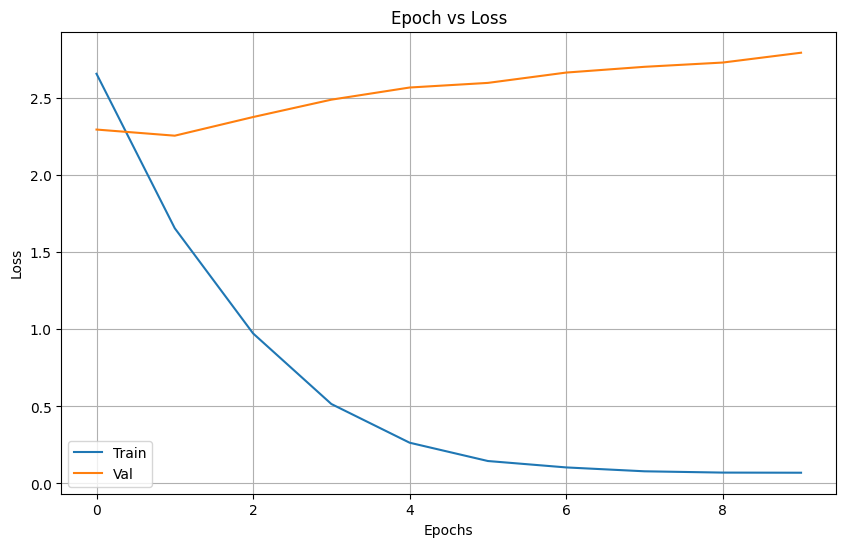

In [39]:
train_losses = history.history['loss']
val_losses = history.history['val_loss']

plt.figure(figsize=(10, 6))

plt.plot(range(len(train_losses)), train_losses, label='Train')
plt.plot(range(len(train_losses)), val_losses, label='Val')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()

plt.show()

In [40]:
model.save_weights('/content/drive/MyDrive/baseline_fine_tuned_model_weights_kw.h5')

In [41]:
input_ids = tokenizer("Hello, my dog is cute", return_tensors="tf")["input_ids"]
input_ids

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=
array([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]],
      dtype=int32)>

In [42]:
outputs = model(input_ids, labels=input_ids, output_hidden_states=True)
outputs[2][0].shape

TensorShape([1, 8, 768])